In [37]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import lib
import squarify

In [39]:
geosra_pd = pd.read_parquet('../data/processed/geosra_clusters.parquet.gzip')
def nombre_decimales(nombre):
    if nombre == np.NaN:
        return np.NaN
    chaine = str(nombre)
    index_point = chaine.find('.')
    if index_point == -1:
        return np.NaN
    return len(chaine) - index_point - 1
geosra_pd["latitude_precision"] = geosra_pd["latitude"].apply(nombre_decimales)
geosra_pd["longitude_precision"] = geosra_pd["longitude"].apply(nombre_decimales)
file = gpd.datasets.get_path('naturalearth_lowres')
countries = gpd.read_file(file)
df_latlon = geosra_pd[geosra_pd['has_latlon'] == True]
df_latlon['geometry'] = [Point(xy) for xy in zip(df_latlon['longitude'],df_latlon['latitude'])]
gdf_latlon = gpd.GeoDataFrame(df_latlon, geometry='geometry')
gdf_latlon.crs = 'EPSG:4326'
fig, ax = plt.subplots(figsize=(10, 6))
countries.plot(ax=ax ,edgecolor='black', facecolor='white')
colors = ["darkorange","limegreen","darkred","rebeccapurple","saddlebrown","pink","gray","lightgreen","cyan","black"]
cmap_custom = mcolors.ListedColormap(colors)
gdf_latlon.plot("cluster_class", cmap=cmap_custom, ax=ax, markersize=1)
ax.set_facecolor('lightblue')
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.set_xticks([])
ax.set_yticks([])

MemoryError: Unable to allocate 48.2 MiB for an array with shape (6312860,) and data type object

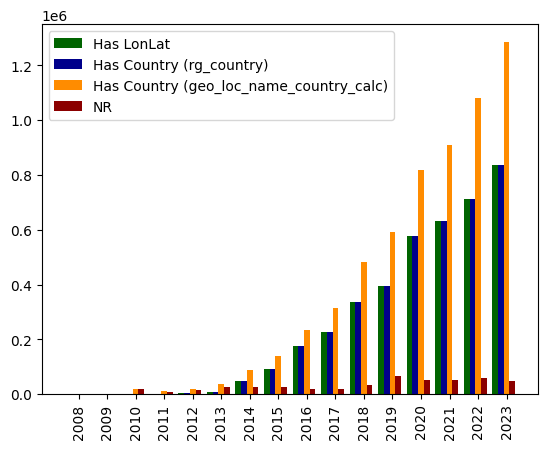

In [ ]:
datas = []
for year in range(2008,2024):
    data_year = geosra_pd[geosra_pd["release_year"] == year]
    data_lonlat = len(data_year[data_year["has_latlon"] == True])
    data_country_1 = len(data_year["geo_loc_name_country_calc"].notnull())
    data_country_2 = len(data_year[data_year["rg_country"] != ''])
    data_nothing = len(data_year[(data_year["has_latlon"].isnull()) & (data_year["geo_loc_name_country_calc"].isnull()) & (data_year["rg_country"] == '')])
    datas.append({"Has LonLat":data_lonlat,"Has Country (rg_country)":data_country_2,"Has Country (geo_loc_name_country_calc)":data_country_1,"NR":data_nothing})
df = pd.DataFrame(datas,index=[year for year in range(2008,2024)])

colors = ['darkgreen','darkblue','darkorange','darkred']
lib.hist(df, width_bar=0.2, colors=colors)

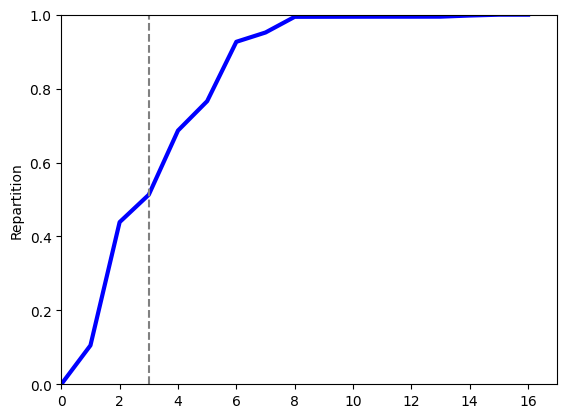

In [ ]:
count = dict(geosra_pd["latitude_precision"].value_counts())
count = dict(sorted(count.items()))
repar = lib.repartition(count, t=0.5)

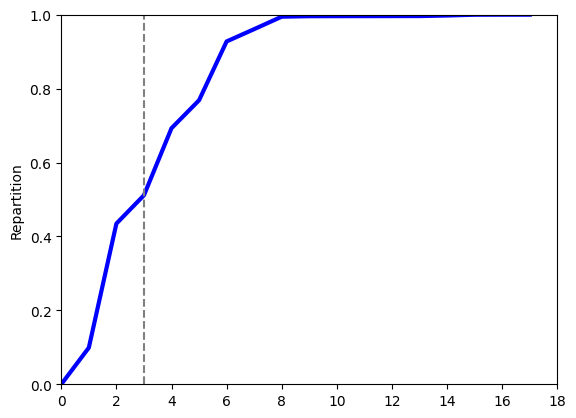

In [ ]:
count = dict(geosra_pd["longitude_precision"].value_counts())
count = dict(sorted(count.items()))
repar = lib.repartition(count, t=0.5)

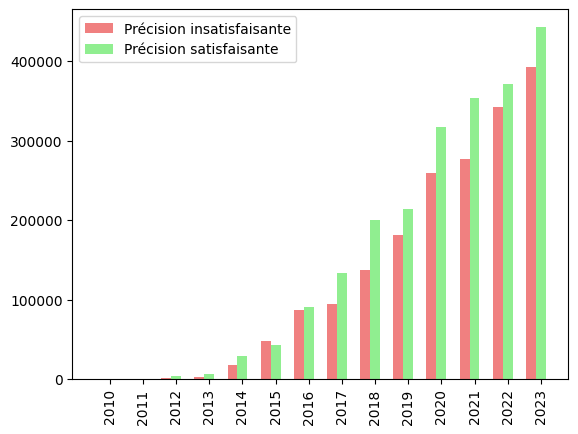

In [ ]:
datas = []
for year in range(2010,2024):
    data_year = geosra_pd[geosra_pd["release_year"] == year]
    data_insat = len(data_year[(data_year["latitude_precision"] <= 2) | (data_year["longitude_precision"] <= 2)])
    data_sat = len(data_year[(data_year["latitude_precision"] > 2) & (data_year["longitude_precision"] > 2)])
    datas.append({"Précision insatisfaisante":data_insat,"Précision satisfaisante":data_sat})
df = pd.DataFrame(datas,index=[year for year in range(2010,2024)])

colors = ['lightcoral','lightgreen']
lib.hist(df, width_bar=0.3, colors=colors)

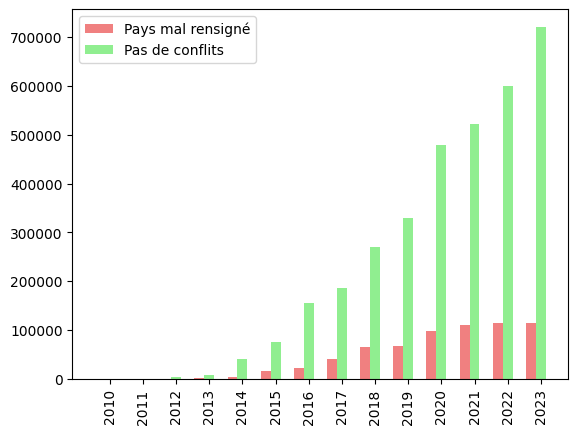

In [ ]:
if 'conflict_country' in geosra_pd.columns:
    geosra_pd.drop('conflict_country', axis=1, inplace=True)
join = gdf_latlon.sjoin(countries, how='left', predicate='intersects')
join = join.drop_duplicates(subset='acc')
countries_dic = {
    'United States': 'United States of America',
    'Korea, Republic of': 'South Korea',
    'Hong Kong': 'China',
    'Russian Federation': 'Russia'
}
for country in countries_dic:
    condition = (join["rg_country"] == country) & (join["name"].notnull())
    join.loc[condition, "rg_country"] = countries_dic[country] 
gdf_latlon.loc[(join["rg_country"] != join["name"]), "conflict_country"] = True
gdf_latlon.loc[(join["rg_country"] == join["name"]), "conflict_country"] = False
to_join = gdf_latlon[["acc", "conflict_country"]]
geosra_pd = geosra_pd.set_index('acc').join(to_join.set_index('acc'))

datas = []
for year in range (2010,2024):
    data_year = geosra_pd[geosra_pd["release_year"] == year]
    data_imp = len(data_year[data_year["conflict_country"] == True])
    data_good = len(data_year[data_year["conflict_country"] == False])
    datas.append({"Pays mal rensigné": data_imp, "Pas de conflits": data_good})
df = pd.DataFrame(datas,index=[year for year in range(2010,2024)])
colors = ['lightcoral','lightgreen']
lib.hist(df, width_bar=0.3, colors=colors)
geosra_pd = geosra_pd.reset_index()

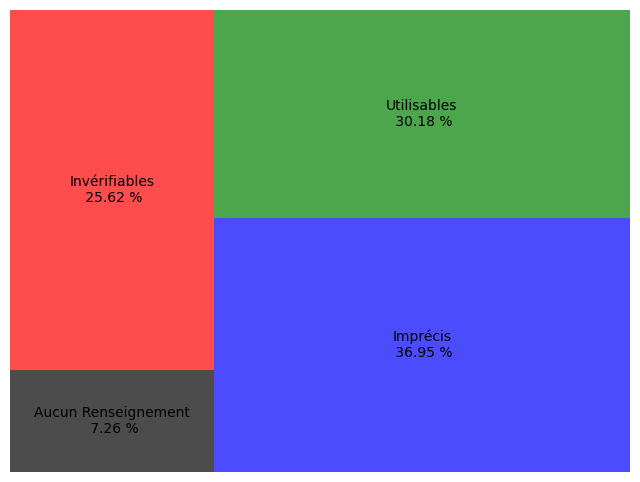

In [ ]:
geosra_pd["eval_data"] = 'Utilisable'
condition_NR = (geosra_pd["has_latlon"].isnull()) & (geosra_pd["geo_loc_name_country_calc"].isnull()) & (geosra_pd["rg_country"] == '')
condition_INV= (geosra_pd["has_latlon"].isnull()) & ((geosra_pd["geo_loc_name_country_calc"] != 'uncalculated') | (geosra_pd["rg_country"] != '') | (geosra_pd["geo_loc_name_country_calc"].notnull()))
condition_IMP= ((geosra_pd["has_latlon"].notnull()) & ((geosra_pd["latitude_precision"] <= 2) | (geosra_pd["longitude_precision"] <= 2))) | (geosra_pd["conflict_country"] == True)

geosra_pd.loc[condition_NR, "eval_data"] = 'Aucun Renseignement'
geosra_pd.loc[condition_INV,"eval_data"] = 'Inverifiable'
geosra_pd.loc[condition_IMP,"eval_data"] = 'Imprecis'
nb_NR = len(geosra_pd[condition_NR]) / len(geosra_pd) 
nb_INV= len(geosra_pd[condition_INV]) / len(geosra_pd) 
nb_INP= len(geosra_pd[condition_IMP]) / len(geosra_pd) 
good  = 1 - (nb_NR + nb_INV + nb_INP)
sizes = [nb_NR, nb_INV, nb_INP, good]
labels = [f"Aucun Renseignement\n {np.round(nb_NR*100, decimals=2)} %", f"Invérifiables\n {np.round(nb_INV*100, decimals=2)} %", f"Imprécis\n {np.round(nb_INP*100, decimals=2)} %", f"Utilisables\n {np.round(good*100, decimals=2)} %"]
colors = ["black", "red", "blue", "green"]
plt.figure(figsize=(8, 6))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.7)
plt.axis('off')
plt.show()


In [ ]:
geosra_pd["release_date"] = geosra_pd["releasedate"]
geosra_propre = geosra_pd[geosra_pd["eval_data"] == 'Utilisable'][[ 
                            "assay_type",
                            "bioproject",
                            "organism",
                            "cluster_class",
                            "release_date",
                            "release_year",
                            "latitude",
                            "longitude",
                            "latitude_precision",
                            "longitude_precision",
                            "rg_country",
                            ]]
geosra_propre['geometry'] = [Point(xy) for xy in zip(geosra_propre['longitude'],geosra_propre['latitude'])]
geosra_propre = gpd.GeoDataFrame(geosra_propre, geometry='geometry')
geosra_propre.crs = 'EPSG:4326'
fig, ax = plt.subplots(figsize=(10, 6))
countries.plot(ax=ax ,edgecolor='black', facecolor='white')
colors = ["darkorange","limegreen","darkred","rebeccapurple","saddlebrown","pink","gray","lightgreen","cyan","black"]
cmap_custom = mcolors.ListedColormap(colors)
geosra_propre.plot("cluster_class", cmap=cmap_custom, ax=ax, markersize=1)
ax.set_facecolor('lightblue')
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.set_xticks([])
ax.set_yticks([])

KeyError: 'eval_data'

In [ ]:
geosra_propre.to_parquet("../data/processed/geosra_clean.parquet.gzip")

In [ ]:
geosra_pd[geosra_pd["bioproject"] != geosra_pd["acc"]]

,acc,bioproject,organism,assay_type,instrument,librarylayout,libraryselection,librarysource,geo_loc_name_country_calc,geo_loc_name_country_continent_calc,...,rg_country_code,rg_city,rg_country,gc_continent,gc_continent_code,cluster_class,release_year,conflict_country,eval_data,release_date
